# Visualized AIMD EXAFS from FEFF
Data courtesy of Micah Prange and Eugene Ilton

In [45]:
import utils
import wavelet_transform
from importlib import reload
from PIL import Image
from ipywidgets import *
import umap
import itertools

utils = reload(utils)
wavelet_transform = reload(wavelet_transform)
from utils import *

## Get data and visualize

In [2]:
datafiles = os.listdir('Data/')
Data = np.array([read_file(f'Data/{filename}') for filename in datafiles])
kweight = 3
print(Data.shape)

(839, 414, 4)


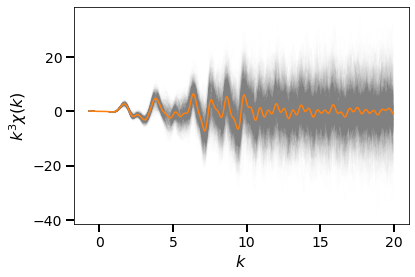

In [49]:
fig, ax = plt.subplots(figsize=(6, 4))
avg_k = np.average(Data[:, :, 0], axis=0)
avg_chi_of_k = np.average(Data[:, :, 1], axis=0)
std_of_chi = np.std(Data[:, :, 1], axis=0, ddof=1)

N = len(std_of_chi)

for run in Data:
    plt.plot(run[:, 0], run[:, 0]**kweight * run[:, 1], '-', c='gray', alpha=0.003)
plt.plot(avg_k, avg_k**kweight * avg_chi_of_k, '-', c=plt.cm.tab20(2), alpha=1.)

#ax.fill_between(avg_k, avg_k**kweight * (avg_chi_of_k + 3 * std_of_chi / np.sqrt(N)),
#                avg_k**kweight * (avg_chi_of_k - 3 * std_of_chi / np.sqrt(N)),
#                color=plt.cm.tab20(0), alpha=0.9)
#plt.xlim(12, 17)

ax.tick_params(direction='out', width=2, length=8, which='major', labelsize=14)
ax.set_xlabel('$k$', fontsize=16)
ax.set_ylabel('$k^' + f'{kweight}' + '\chi(k)$', fontsize=16)
plt.savefig('Figures/chi_of_k.png', dpi=800, bbox_inches='tight')

Notes:

How to remove donuts if they're numerical artifacts?

UML/ clustering on wavelets (PCA preprocessing?)

Re vs Imag instead of mod?

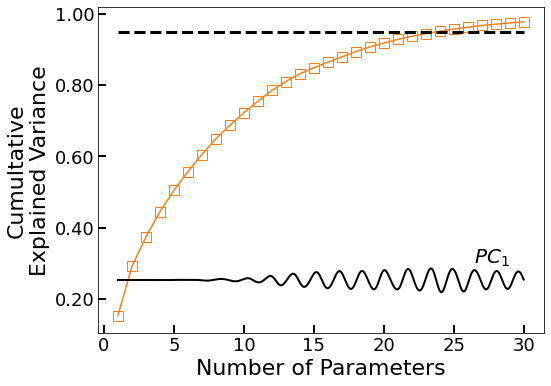

In [4]:
make_scree_plot(Data[:, :, 1] * Data[:, :, 0]**kweight, n=30, mod=5)

In [5]:
Moduli = []
for i in range(len(Data)):
    print(i, end='\r')
    wavelet = wavelet_transform.cauchy_wavelet(Data[i, :, 0], chi=Data[i, :, 1], rmax_out=8, kweight=kweight)
    modulus = np.sqrt(wavelet.real**2 + wavelet.imag**2)
    Moduli.append(modulus)
Moduli = np.array(Moduli)
print(Moduli.shape)
max_mod = np.max(Moduli)

(839, 261, 414)


In [22]:
data = Moduli.reshape(len(Moduli), -1)

from sklearn.decomposition import PCA
pca = PCA()
#pca_components = pca.fit_transform(data)

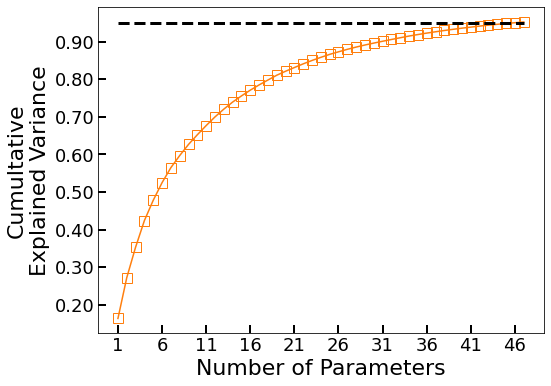

In [7]:
n = 47
threshold = 0.95
mod = 5
x = np.arange(n) + 1
cdf = [np.sum(pca.explained_variance_ratio_[:i + 1]) for i in range(n)]

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x, cdf, 's-', markersize=10, fillstyle='none', color=plt.cm.tab20(2))

ax.plot(x, np.ones(len(x)) * threshold, 'k--', linewidth=3)

xticks = np.arange(0, n, mod) + 1
plt.xticks(xticks, fontsize=18)
plt.yticks(fontsize=18)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.xlabel('Number of Parameters', fontsize=22)
plt.ylabel(f'Cumultative\nExplained Variance', fontsize=22)
ax.tick_params(direction='in', width=2, length=8)

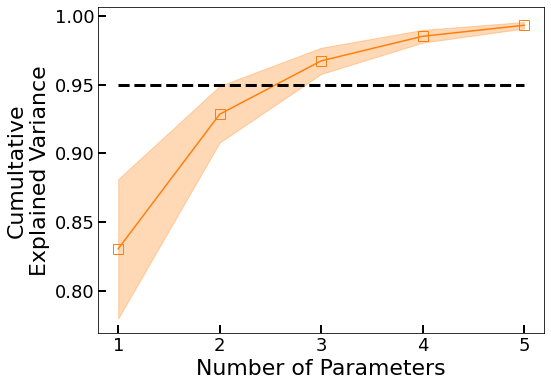

In [12]:
fig, ax = plt.subplots(figsize=(8,6))
n = 5
threshold = 0.95

cdfs = []
for data in Moduli[:150]:
    pca = PCA()
    pca_components = pca.fit_transform(data)
    cdf = [np.sum(pca.explained_variance_ratio_[:i + 1]) for i in range(n)]
    cdfs.append(cdf)
cdfs = np.array(cdfs)

x = np.arange(n) + 1
avg = np.average(cdfs, axis=0)
std = np.std(cdfs, axis=0)
ax.plot(x, avg, 's-', markersize=10, fillstyle='none', color=plt.cm.tab20(2), alpha=1.)
ax.fill_between(x, avg + std, avg - std, color=plt.cm.tab20(2), alpha=0.3)

ax.plot(x, np.ones(len(x)) * threshold, 'k--', linewidth=3)
   
xticks = np.arange(0, n) + 1
plt.xticks(xticks, fontsize=18)
plt.yticks(fontsize=18)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.xlabel('Number of Parameters', fontsize=22)
plt.ylabel(f'Cumultative\nExplained Variance', fontsize=22)
ax.tick_params(direction='in', width=2, length=8)

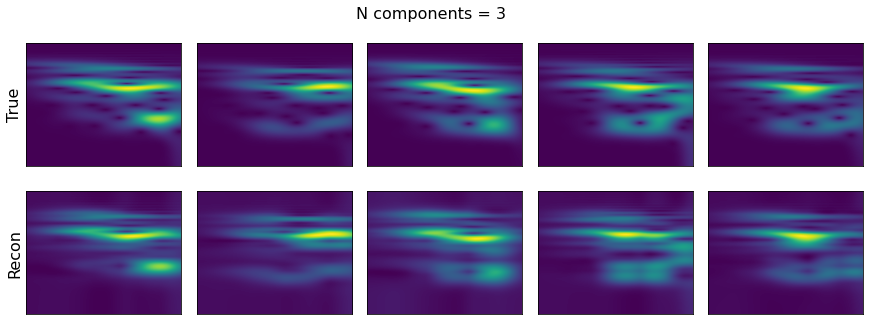

In [9]:
n = 5
n_components = 3
fig, axes = plt.subplots(figsize=(3 * n, 5), nrows=2, ncols=n)
plt.subplots_adjust(wspace=0.1, hspace=0.2)

threshold = 0.9
extent = [0, 1, 0, 1]

for i, data in enumerate(Moduli[:n]):
    pca = PCA(n_components=n_components)
    recon = pca.inverse_transform(pca.fit_transform(data))
    axes[0, i].imshow(data, extent=extent, aspect='auto')
    axes[1, i].imshow(recon, extent=extent, aspect='auto')
    for ax in axes[:, i]:
        ax.set_xticks([])
        ax.set_yticks([])

axes[0, 0].set_ylabel('True', fontsize=16)
axes[1, 0].set_ylabel('Recon', fontsize=16)
plt.suptitle(f'N components = {n_components}', fontsize=16)
plt.show()

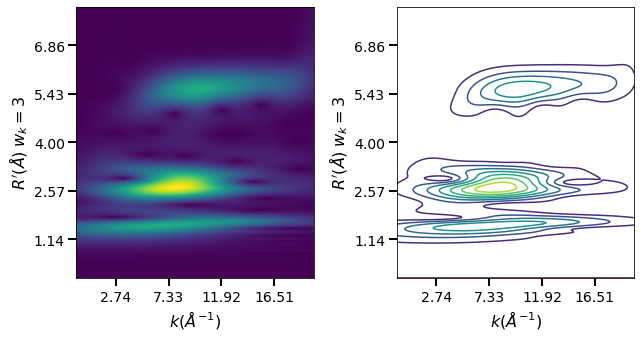

In [21]:
rmax_out = 8
wavelet = wavelet_transform.cauchy_wavelet(avg_k, chi=avg_chi_of_k, rmax_out=rmax_out, kweight=kweight)
modulus = np.sqrt(wavelet.real**2 + wavelet.imag**2) / max_mod

extent = [0, 1, 0, 1]

fig, axes = plt.subplots(figsize=(10, 5), ncols=2)
plt.subplots_adjust(wspace=0.35)

for i, ax in enumerate(axes):
    if i == 0:
        ax.imshow(modulus, origin='lower', extent=extent, aspect='auto')
    else:
        ax.contour(modulus, extent=extent)

    ax.tick_params(direction='out', width=2, length=8, which='major', labelsize=14)
    set_axes(ax, min(avg_k), max(avg_k), nticks=4, axis='x')
    set_axes(ax, 0, rmax_out, nticks=5, axis='y')
    ax.set_ylabel("$R' (\AA) \; w_k=" + f'{kweight}' + "$", fontsize=16)
    ax.set_xlabel('$k (\AA^{-1})$', fontsize=16)

plt.savefig('Figures/avg_wavelet_and_contour.png', dpi=800, bbox_inches='tight')

In [48]:
def plot_contours(i):
    fig, axes = plt.subplots(figsize=(10, 5), ncols=2)
    plt.subplots_adjust(wspace=0.35)

    for j, ax in enumerate(axes): 
        if j == 0:
            ax.imshow(Moduli[i], origin='lower', extent=extent)
        else:
            ax.contour(Moduli[i], extent=extent)

        ax.tick_params(direction='out', width=2, length=8, which='major', labelsize=14)
        set_axes(ax, min(avg_k), max(avg_k), nticks=4, axis='x')
        set_axes(ax, 0, rmax_out, nticks=5, axis='y')
        ax.set_ylabel("$R' (\AA) \; w_k=" + f'{kweight}' + "$", fontsize=16)
        ax.set_xlabel('$k (\AA^{-1})$', fontsize=16)
    
    plt.show()
        
slider = IntSlider(min=0, max=len(Moduli), step=10, value=0, layout=widgets.Layout(width='70%'))
interactive(plot_contours, i=slider)

interactive(children=(IntSlider(value=0, description='i', layout=Layout(width='70%'), max=839, step=10), Outpu…

In [26]:
from sewar.full_ref import mse, rmse, psnr, uqi, ssim, ergas, scc, rase, sam, msssim, vifp

In [27]:
i = 0
print("RMSE: ", rmse(Moduli[i]/255., Moduli[i + 1]/255.))

RMSE:  0.00031992381211767184


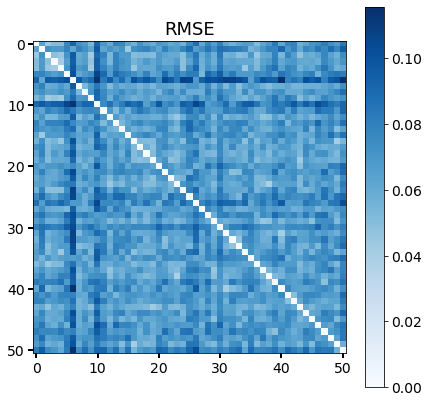

In [44]:
N = len(Moduli)
N = 51
mod = 10
Similarity_matrix = np.zeros((N, N))
for i, j in itertools.product(range(N), range(N)):
    if i <= j:
        score = rmse(Moduli[i] / max_mod, Moduli[j] / max_mod)
        Similarity_matrix[i, j] = score
        Similarity_matrix[j, i] = score
        

fig, ax = plt.subplots(figsize=(7, 7))
plt.imshow(Similarity_matrix, cmap='Blues', interpolation='nearest')
plt.title('RMSE', fontsize=18)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
ax.set_yticks(np.arange(0, N, mod))
ax.set_xticks(np.arange(0, N, mod))
ax.tick_params(direction='out', width=2, length=5, which='major', labelsize=14)
plt.show()

In [47]:
images = []
mods = []
for i in range(len(Data)):
    print(i, end='\r')
    wavelet = wavelet_transform.cauchy_wavelet(Data[i, :, 0], chi=Data[i, :, 1], rmax_out=8, kweight=kweight)
    modulus = np.sqrt(wavelet.real**2 + wavelet.imag**2)
    modulus = np.flip(modulus, axis=0)  # put origin in bottom left (not top left)
    img = Image.fromarray(np.uint8(plt.cm.viridis(modulus / max_mod) * 255))
    images.append(img)
    mods.append(modulus)

frame_one = images[0]
frame_one.save("wavelets_long_k_cubed.gif", format="GIF", append_images=images,
               save_all=True, duration=250, loop=0)  # duration in ms